In [ ]:
# https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

'''

Used models to predict the Appliances Watt usage every 10 min. 

Tried to calculate correlation between the features, and used some heirarchical clustering code to pick the most relevant 
features, and a diagram to display the clusters of features. 

Then used various algorithms, with grid search cross validation to pick the best model. I was getting much better results 
trying to predict the log of the y variable. Went with a Random forest that had R^2 of about 0.60 or so. 

'''

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import datetime 

from sklearn import preprocessing 


In [6]:
filename_prefix = 'C://Users/Tim/Downloads/energydata_complete.csv'

dataDF = pd.read_csv(filename_prefix, index_col = 'date', parse_dates = True)

In [16]:
dataDF

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,month
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,17,1
2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,17,1
2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,17,1
2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,17,1
2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,17,5
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,17,5
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,17,5


In [15]:
dataDF['hour'] = dataDF.index.hour
dataDF['month'] = dataDF.index.month

In [17]:
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

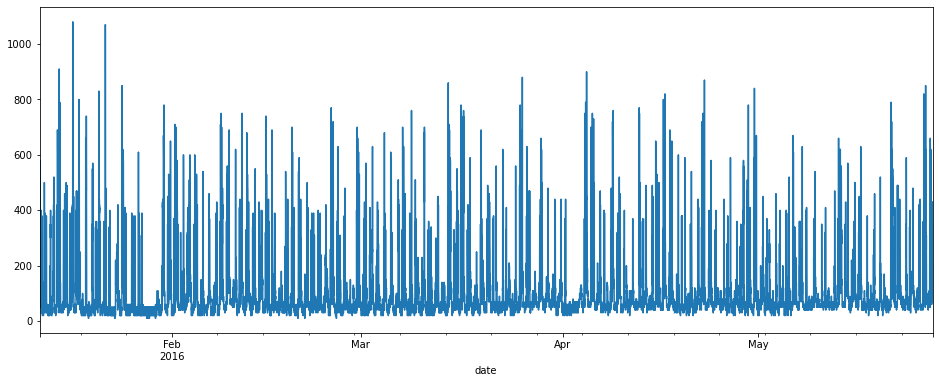

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

dataDF['Appliances'].plot()

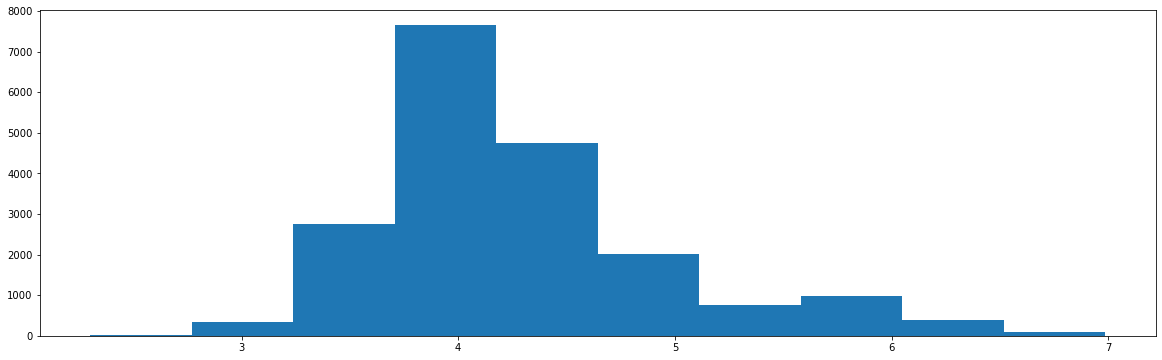

In [179]:
import matplotlib.pyplot as plt

_ = plt.hist(np.array(np.log(dataDF['Appliances'])), bins= 10)

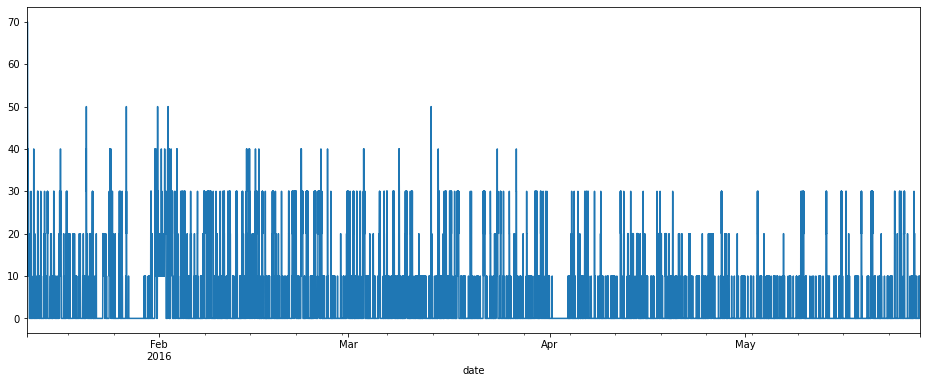

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

dataDF['lights'].plot()

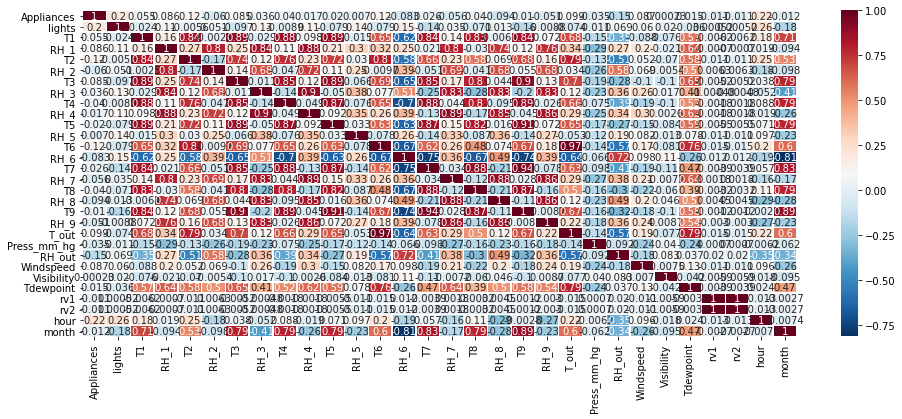

In [18]:
import seaborn as sb

pearsoncorr = dataDF.corr(method='pearson')

sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [34]:
dataDF.describe().iloc[:, 10:]

,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,month
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,11.502002,3.101647
std,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,6.921953,1.339200
min,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000,1.000000
25%,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,6.000000,2.000000
50%,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,12.000000,3.000000
75%,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,17.000000,4.000000
max,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,23.000000,5.000000


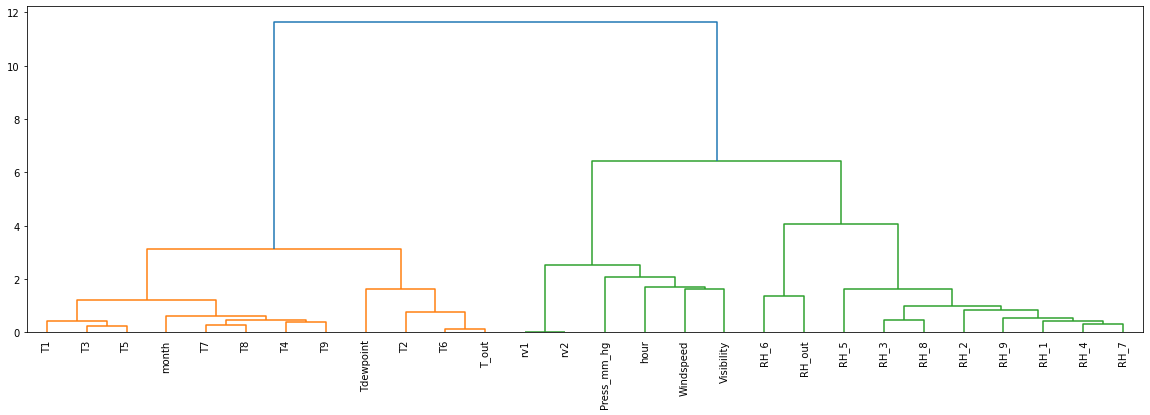

In [23]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

X= dataDF.drop(columns = ['Appliances', 'lights'])
corr = spearmanr(X).correlation

corr_linkage = hierarchy.ward(corr)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 6

dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.tolist(), leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

In [24]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [88]:
feat_cols = list(X.columns) #list(X.columns[selected_features])
feat_cols

['T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 'rv1',
 'rv2',
 'hour',
 'month']

In [ ]:
dataDF['']

In [183]:

y_label = 'Appliances'
Xy = dataDF[feat_cols + [y_label]]

#X_arr = np.array(Xy.drop(columns = ['class']))
#Y_arr = np.array(Xy['class'])

X_arr = Xy.drop(columns = [y_label])
Y_arr = np.log(Xy[y_label])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_arr, Y_arr, test_size=0.60, random_state=42)

In [181]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import decomposition


other_cols = ['hour', 'month']
other_transformer = Pipeline(steps=[('identity',preprocessing.FunctionTransformer())])


numirical_cols = [c for c in list(dataDF.columns) if (c != 'class')]
categorical_transformer = Pipeline(steps=[('ordinal',preprocessing.OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, num_cols), ('cat', categorical_transformer, categorical_cols)])


clf = Pipeline(steps=[('preprocessor', preprocessor), #('pca', decomposition.PCA()),
                      ('classifier', ensemble.RandomForestClassifier())])


#dataDF_trans = preprocessor.fit_transform(dataDF)



NameError: name 'numerical_transformer' is not defined

In [203]:
from sklearn import tree, ensemble, neighbors, neural_network

clf = ensemble.GradientBoostingRegressor(max_depth=7, n_estimators=300) # -- 63% 
#clf = neighbors.KNeighborsRegressor(weights='distance') # -- 63%

clf.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=7, n_estimators=300)

In [204]:
score = clf.score(X_test, y_test)
score

0.5932775754828312

In [205]:
y_pred = clf.predict(X_test)

In [206]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import math

# report performance
mse = mean_squared_error(y_test, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))
print('MAPE: '+str(mape))

MSE: 0.17609937406600257
MAE: 0.28022084444185
RMSE: 0.41964195937251386
MAPE: 0.06380095009295071


In [190]:
cv_loss = make_scorer(mean_absolute_error, greater_is_better = False)

parameters = {'n_neighbors': [5, 10, 30], 'weights': ['uniform', 'distance']}
model =  neighbors.KNeighborsRegressor()

#parameters = {'learning_rate': [0.1], 'n_estimators': [150, 300, 500], 'max_depth': [3, 5, 7]}
#model = ensemble.GradientBoostingRegressor()

cv_ = model_selection.GridSearchCV(model, parameters, cv = model_selection.KFold(n_splits = 4), scoring=cv_loss)

cv_.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 30],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [191]:
cv_.best_estimator_

KNeighborsRegressor(weights='distance')

In [192]:
cv_.best_score_

-0.380929740018557

In [197]:
feat_impDF = pd.DataFrame(zip(feat_cols, clf.feature_importances_), columns = ['feature', 'importance'])

feat_impDF.sort_values('importance', ascending = False)

AttributeError: 'KNeighborsRegressor' object has no attribute 'feature_importances_'

In [63]:
zip(y_test, y_pred)

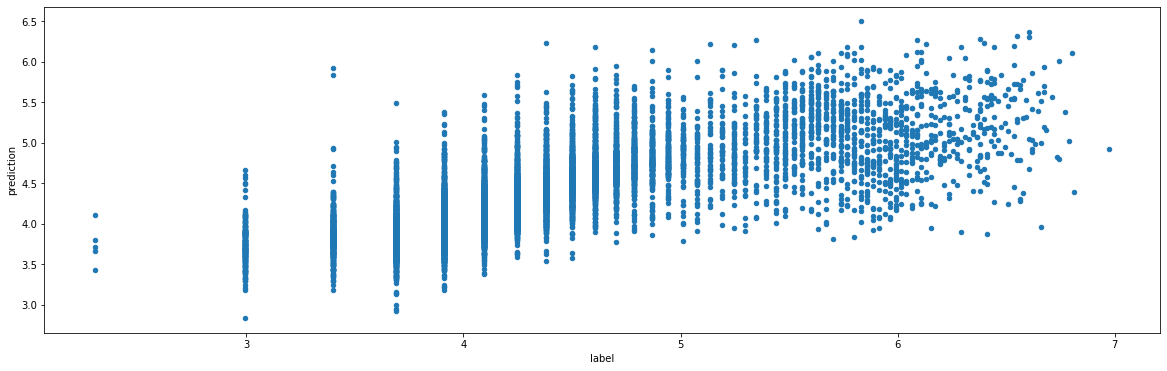

In [207]:
resultsDF = pd.DataFrame(zip(y_test, y_pred), columns = ['label', 'prediction'])
resultsDF.plot.scatter(x = 'label', y = 'prediction')